In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from collections import OrderedDict
import pandas as pd
import numpy as np
from recs.jaxmodels.cf import mf
from recs.evaluator import evaluate
from recs import utils
from recs.jaxmodels import GRU4Rec, GRU4RecConfig
from recs.dataset import session_parallel_dataset

import optax
from flax.training import train_state
from flax.training import common_utils
from flax import linen as nn

import tensorflow as tf
from tqdm.notebook import tqdm

import jax
from jax import numpy as jnp

# MF

In [93]:
def predict_items(params, data, k):
    users = np.unique(data[:, 0])
    pred_dic = {}
    for u in users:
        pred_dic[u] = np.asarray(mf.predict(params, u, k))
    return pd.DataFrame(pred_dic.items(), columns=["userId", "itemIds"])

In [94]:
df = pd.read_csv("/home/inoue/work/dataset/ml-100k/rating.csv")
display(df)
df.columns = ["userId", "itemId", "rating", "timestamp"]
df["userId"] -= 1
df["itemId"] -= 1
num_users, num_items = df["userId"].max() + 1, df["itemId"].max() + 1

df = df.astype(np.int32)

def txs_train_test_split(txs, split_date):
    txs_train, txs_test = txs[txs['timestamp'] < split_date], txs[txs['timestamp'] >= split_date]
    return txs_train, txs_test

split_ind = df.loc[int(len(df)*0.8), "timestamp"]

train_d, test_d = txs_train_test_split(df, split_ind)

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [95]:
data = tf.data.Dataset.from_tensor_slices(train_d[["userId", "itemId", "rating"]].values)
train_data = data.shuffle(len(data)).batch(64).prefetch(1)

In [96]:
params = mf.init_params(num_users, num_items, 10)

In [97]:
true_items = utils.get_y_trues(test_d)
k = 20
for epoch in range(75):
    batch_loss = 0.
    with tqdm(train_data.shuffle(len(train_data)).as_numpy_iterator(), desc=f"[Epoch {epoch+1}]", total=len(train_data)) as tm:
        for i, batch in enumerate(tm):
            params, error = mf.update(params, batch, alpha=0.005, lam=0.05)
            batch_loss += error
            tm.set_postfix(OrderedDict(loss=batch_loss / (i + 1)))
        
    batch_loss /= len(train_data)


    
    if epoch % 5 == 0:
        pred_items = predict_items(params, test_d.values[:, :3], k)
        eval_scores = evaluate.evaluate(true_items, pred_items, k)
    
        for key in eval_scores.keys():
            print(f"{key}@{k} : {eval_scores[key]:.4f} ", end="")

[Epoch 1]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0047 map@20 : 0.0044 recall@20 : 0.0016 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 2]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 3]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 4]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 5]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 6]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0055 map@20 : 0.0049 recall@20 : 0.0019 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 7]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 8]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 9]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 10]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 11]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0052 map@20 : 0.0057 recall@20 : 0.0019 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 12]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 13]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 14]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 15]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 16]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0049 map@20 : 0.0058 recall@20 : 0.0027 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 17]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 18]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 19]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 20]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 21]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0055 map@20 : 0.0060 recall@20 : 0.0033 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 22]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 23]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 24]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 25]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 26]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0057 map@20 : 0.0063 recall@20 : 0.0033 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 27]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 28]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 29]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 30]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 31]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0060 map@20 : 0.0066 recall@20 : 0.0034 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 32]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 33]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 34]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 35]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 36]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0062 map@20 : 0.0067 recall@20 : 0.0035 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 37]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 38]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 39]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 40]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 41]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0067 map@20 : 0.0068 recall@20 : 0.0037 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 42]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 43]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 44]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 45]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 46]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0070 map@20 : 0.0069 recall@20 : 0.0037 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 47]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 48]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 49]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 50]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 51]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0067 map@20 : 0.0066 recall@20 : 0.0036 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 52]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 53]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 54]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 55]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 56]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0076 map@20 : 0.0066 recall@20 : 0.0035 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 57]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 58]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 59]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 60]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 61]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0079 map@20 : 0.0069 recall@20 : 0.0037 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 62]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 63]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 64]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 65]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 66]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0077 map@20 : 0.0070 recall@20 : 0.0040 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 67]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 68]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 69]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 70]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 71]:   0%|          | 0/1253 [00:00<?, ?it/s]

precision@20 : 0.0079 map@20 : 0.0071 recall@20 : 0.0038 ndcg@20 : 0.0000 mrr@20 : 0.0000 

[Epoch 72]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 73]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 74]:   0%|          | 0/1253 [00:00<?, ?it/s]

[Epoch 75]:   0%|          | 0/1253 [00:00<?, ?it/s]

In [98]:
k=20
pred_items = predict_items(params, test_d.values[:, :3], k)
eval_scores = evaluate.evaluate(true_items, pred_items, k)
    
for key in eval_scores.keys():
    print(f"{key}@{k} : {eval_scores[key]:.4f} ", end="")

precision@20 : 0.0082 map@20 : 0.0072 recall@20 : 0.0042 ndcg@20 : 0.0001 mrr@20 : 0.0002 

# GRU4Rec

In [5]:
data = pd.read_pickle("/home/inoue/work/dataset/RC15/derived/train.df")

In [6]:
train_data, total_length = session_parallel_dataset(batch_size = 500)

In [8]:
total_length = len(data) // 500 + 1

In [7]:
total_length

63422

In [8]:
num_items = data.itemId.max() + 1

config = GRU4RecConfig(hidden_size=100, output_size=num_items, batch_size=500, dropout_hidden=0.)

In [9]:
def create_train_state(key, config):
    model = GRU4Rec(config)
    hidden = model.init_hidden(config.batch_size, config.hidden_size, config.num_layers)
    params = model.init(key, jnp.ones((config.batch_size,), dtype=jnp.float32), hidden)["params"]
    tx = optax.sgd(config.learning_rate, config.momentum)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx), hidden, model

In [10]:
@jax.jit
def train_step(state, x, y, mask, hidden):
    mask = jnp.expand_dims(mask, axis=-1)
    hidden = mask * hidden
    def loss_fn(params, hidden):
        logits, hidden = model.apply({"params":params}, x, hidden)
        one_hot_labels = jax.nn.one_hot(y, num_classes=logits.shape[-1])
        logits, one_hot_labels = jnp.squeeze(logits), jnp.squeeze(one_hot_labels)
        loss = -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))
        return loss, hidden
    (loss, hidden), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, hidden)
    state = state.apply_gradients(grads=grads)
    return state, loss, hidden

In [11]:
loss_list = []
num_epochs = 10
state, hidden, model = create_train_state(jax.random.PRNGKey(0), config)

for epoch in range(num_epochs):
    with tqdm(enumerate(train_data), desc="training", total=total_length) as ts:
        for i, batch in ts:
            batch = common_utils.shard(jax.tree_map(lambda x: x._numpy(), batch))
            inputs, targets, masks = batch["input"], batch["target"], batch["mask"]
            state, metrics, hidden = train_step(state, inputs, targets, masks, hidden)
            loss_list.append(loss[0])
            ts.set_postfix(OrderedDict(loss=np.mean(loss_list)))

2022-05-19 16:31:44.186979: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-05-19 16:31:44.187010: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-05-19 16:31:44.187043: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2141] Execution of replica 0 failed: INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


XlaRuntimeError: INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support

In [69]:
test_data = session_parallel_dataset(path="/home/inoue/work/dataset/RC15/derived/test.df", batch_size=500)

In [71]:
test_data, test_len = test_data
test_len

3982

In [87]:
k =20

hidden = model.init_hidden(config.batch_size, config.hidden_size, config.num_layers)
recalls = []
for i, batch in tqdm(enumerate(test_data), desc="evaluating"):
    batch = common_utils.shard(jax.tree_map(lambda x: x._numpy(), batch))
    inputs, targets, masks = jnp.squeeze(batch["input"]), jnp.squeeze(batch["target"]), jnp.squeeze(batch["mask"])
    logits, hidden = jax.jit(model.apply)({"params":state.params}, inputs, hidden)
    
    _, indices = jax.lax.top_k(logits, k=k)
    targets = jnp.expand_dims(targets, axis=-1)
    recall = jnp.sum(indices == targets) / targets.shape[0]
    recalls += [np.asarray(recall)]

evaluating:   0%|          | 0/3982 [00:00<?, ?it/s]

In [99]:
np.mean(recalls), np.std(recalls)

(0.0095844045, 0.027512396)

In [103]:
recalls = np.asarray(jnp.stack(recalls))

In [104]:
np.mean(recalls), np.std(recalls)

(0.0095844045, 0.027512396)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ffb605e42b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ffb605e4850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ffb6064ffa0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ffb605e4df0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ffb605f5100>],
 'means': []}

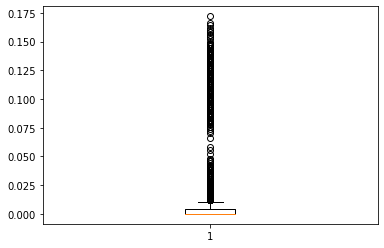

In [110]:
import matplotlib.pyplot as plt
plt.boxplot(recalls)